In [1]:
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import ShortTermFeatures
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import os

In [3]:
def preProcess( fileName ):
    [Fs, x] = audioBasicIO.read_audio_file(fileName) #A

    #B
    if( len( x.shape ) > 1 and  x.shape[1] == 2 ):
        x = np.mean( x, axis = 1, keepdims = True )
    else:
        x = x.reshape( x.shape[0], 1 )
    #C
    F, f_names = ShortTermFeatures.feature_extraction(
        x[ :, 0 ],
        Fs, 0.050*Fs,
        0.025*Fs
    )
    
    return (f_names, F)

In [4]:
samples_txt = open("/Users/samlyon/Desktop/ISYE - 6740/Project/Samples to use.txt","r")

In [5]:
st = samples_txt.read()

In [6]:
import re

In [7]:
l1 = re.findall(r"(?<=Unknown Album/).*?(?=m4a)", st)

In [8]:
l2 = re.findall(r"(?<=Voice Memos/).*?(?=m4a)", st)

In [9]:
l3 = l1 + l2 
l3.insert(0, "0. Water on Tupperware top.")

In [10]:
for i in range(len(l3)):
    l3[i] = l3[i] + "wav"

In [11]:
labels = l3

In [12]:
def getChromagram( audioData ):
    
    # A
    temp_data =  audioData[ 21 ].reshape( 
        1, 
        audioData[ 21 ].shape[0] 
    )
    chronograph = temp_data
    
    # B
    for i in range( 22, 33 ):
        temp_data =  audioData[ i ].reshape( 
            1, 
            audioData[ i ].shape[0] 
        )
        chronograph = np.vstack( [ chronograph,  temp_data ] )
    
    return chronograph

In [13]:
def getNoteFrequency( chromagram ):
    
    numberOfWindows = chromagram.shape[1] #A
    
    freqVal = chromagram.argmax( axis = 0 ) #B
    
    histogram, _ = np.histogram( freqVal, bins = 12 ) #C
    
    normalized_hist = histogram.reshape( 1, 12 ).astype( float ) / numberOfWindows #D
    
    return normalized_hist

In [14]:
pp = preProcess("/Users/samlyon/Desktop/ISYE - 6740/Project/Samples/0. Water on Tupperware top.wav")

In [15]:
cg = getChromagram(pp[1])

In [16]:
nf = getNoteFrequency(cg)

In [17]:
def make_df(filelist):
    sa = getNoteFrequency(getChromagram(
        preProcess("/Users/samlyon/Desktop/ISYE - 6740/Project/Samples/0. Water on Tupperware top.wav")[1]))
    for i in filelist[1:]:
        pp = preProcess("/Users/samlyon/Desktop/ISYE - 6740/Project/Samples/" + i)
        cg = getChromagram(pp[1])
        nf = getNoteFrequency(cg)
        sa = np.vstack((sa, nf))
    return sa

In [18]:
nf

array([[0.00552486, 0.        , 0.        , 0.00552486, 0.02762431,
        0.        , 0.09392265, 0.32596685, 0.        , 0.5359116 ,
        0.        , 0.00552486]])

In [19]:
samples = make_df(labels)

In [20]:
samples_df = pd.DataFrame(samples, columns = [ "G#", "G", "F#", "F", "E", "D#", "D", "C#", "C", "B", "A#", "A" ])

In [21]:
samples_df

,G#,G,F#,F,E,D#,D,C#,C,B,A#,A
0,0.005525,0.000000,0.000000,0.005525,0.027624,0.000000,0.093923,0.325967,0.000000,0.535912,0.000000,0.005525
1,0.159869,0.063622,0.039152,0.008157,0.001631,0.011419,0.200653,0.249592,0.215334,0.024470,0.024470,0.001631
2,0.006993,0.000000,0.310023,0.002331,0.016317,0.018648,0.202797,0.004662,0.011655,0.006993,0.410256,0.009324
3,0.182222,0.008889,0.393333,0.008889,0.320000,0.000000,0.004444,0.000000,0.000000,0.000000,0.053333,0.028889
4,0.170526,0.004211,0.063158,0.054737,0.054737,0.075789,0.107368,0.006316,0.046316,0.254737,0.151579,0.010526
...,...,...,...,...,...,...,...,...,...,...,...,...
162,0.120921,0.001919,0.211132,0.274472,0.021113,0.000000,0.046065,0.072937,0.001919,0.055662,0.117083,0.076775
163,0.087251,0.183544,0.243219,0.100814,0.056510,0.047920,0.059675,0.001356,0.006781,0.056058,0.146926,0.009946
164,0.348299,0.000000,0.014966,0.072109,0.062585,0.004082,0.157823,0.000000,0.059864,0.014966,0.263946,0.001361
165,0.278061,0.000000,0.035714,0.176020,0.232143,0.005102,0.053571,0.000000,0.002551,0.122449,0.071429,0.022959


In [22]:
m, n = samples.shape
C = np.matmul(samples.T, samples)/m

# pca the data
d = 2  # reduced dimension
V,S,_ = np.linalg.svd(C)
V = V[:, :d]

pdata = np.dot(samples,V)

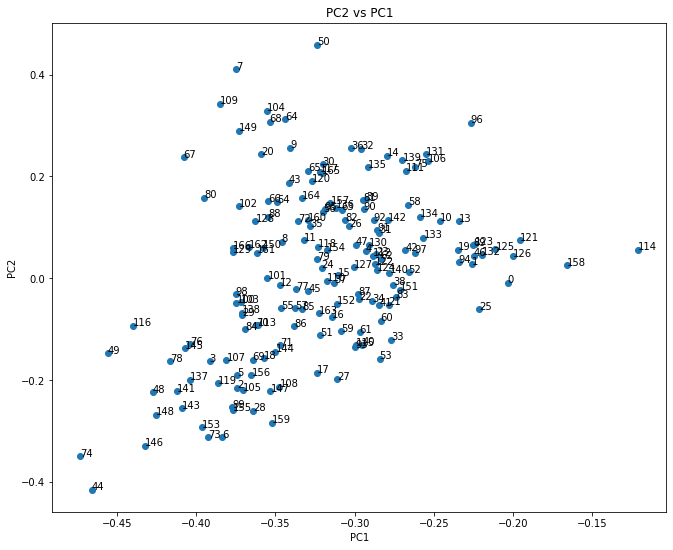

In [23]:
plt.rcParams['figure.figsize'] = [11, 9]

plt.scatter(pdata[:, 0], pdata[:, 1])
plt.title('PC2 vs PC1')
plt.xlabel('PC1')
plt.ylabel('PC2')

for i in range(pdata.shape[0]):
    plt.text(pdata[i,0], pdata[i,1], str(i))
    
from matplotlib.pyplot import figure

plt.show()

-----

## KMeans##

In [24]:
import sklearn.cluster as skc
import sklearn.metrics as skm

In [25]:
li = list(range(2,21))
l = []
l1 = []
for i in li:
    mod = skc.KMeans(n_clusters = i, init = 'random', random_state = 0)
    mod.fit_predict(samples)
    l.append(mod.inertia_)
    l1.append(skm.silhouette_score(samples, mod.labels_))

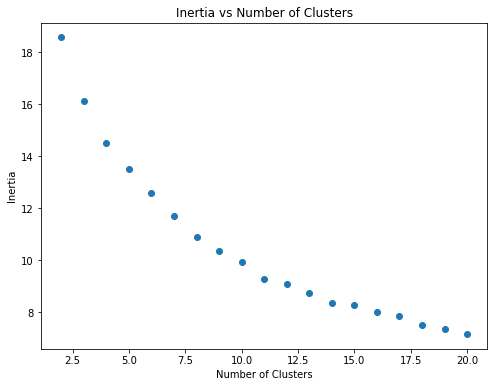

In [26]:
plt.rcParams['figure.figsize'] = [8,6]

plt.scatter(li, l)
plt.title('Inertia vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

plt.show()

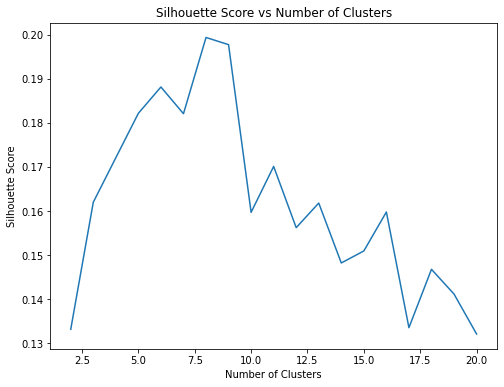

In [27]:
plt.rcParams['figure.figsize'] = [8,6]

plt.plot(li, l1)
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.show()

In [28]:
mod = skc.KMeans(n_clusters = 8, init = 'random', random_state = 0)
mod_labels = mod.fit_predict(samples)

In [29]:
lc = pd.DataFrame(labels, columns = ["label"])

In [30]:
lc['cluster'] = mod_labels

In [158]:
np.array(lc[lc['cluster'] == 7].index.values)

array([  9,  30,  36,  39,  47,  58,  66,  67,  80,  81, 104, 109, 120,
       129, 160, 164, 165, 166])

In [32]:
pca_df = pd.DataFrame(pdata, columns = ['PCA1', 'PCA2'])

In [33]:
pca_df['Index'] = np.array(range(167))
pca_df['Cluster'] = mod_labels

In [34]:
pca_df

,PCA1,PCA2,Index,Cluster
0,-0.203281,-0.008993,0,1
1,-0.226008,0.028102,1,5
2,-0.374250,-0.215183,2,3
3,-0.391690,-0.163524,3,2
4,-0.293074,0.052711,4,1
...,...,...,...,...
162,-0.367023,0.060382,162,0
163,-0.322385,-0.068598,163,2
164,-0.333341,0.157380,164,7
165,-0.320655,0.206741,165,7


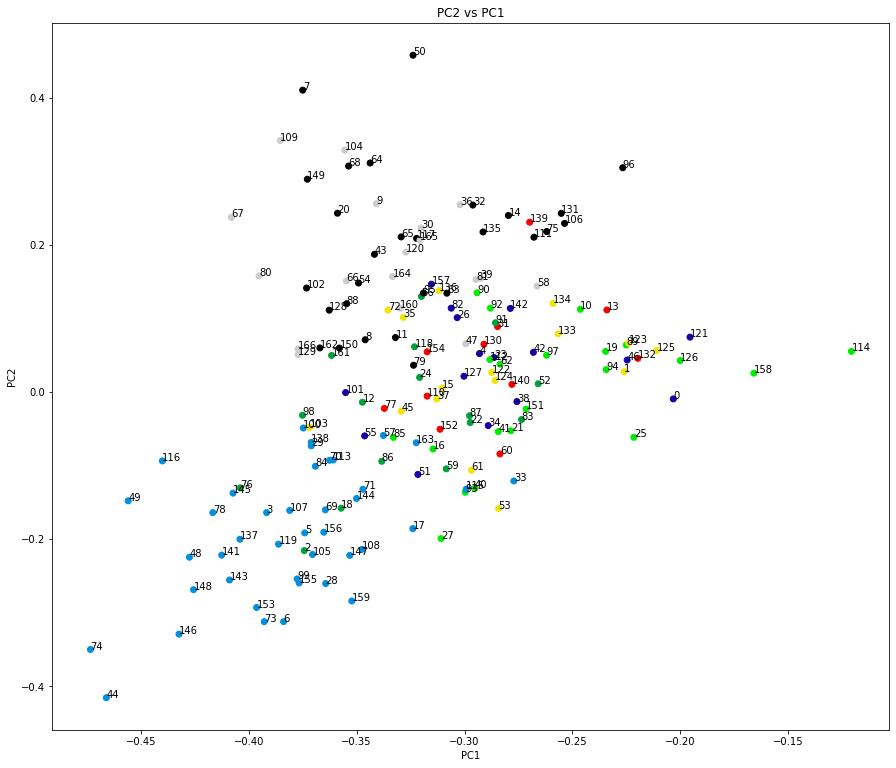

In [35]:
plt.rcParams['figure.figsize'] = [15, 13]

plt.scatter(pca_df['PCA1'], pca_df['PCA2'], c = pca_df['Cluster'], cmap = "nipy_spectral")
plt.title('PC2 vs PC1')
plt.xlabel('PC1')
plt.ylabel('PC2')

for i in range(pdata.shape[0]):
    plt.text(pdata[i,0], pdata[i,1], str(i))

plt.show()

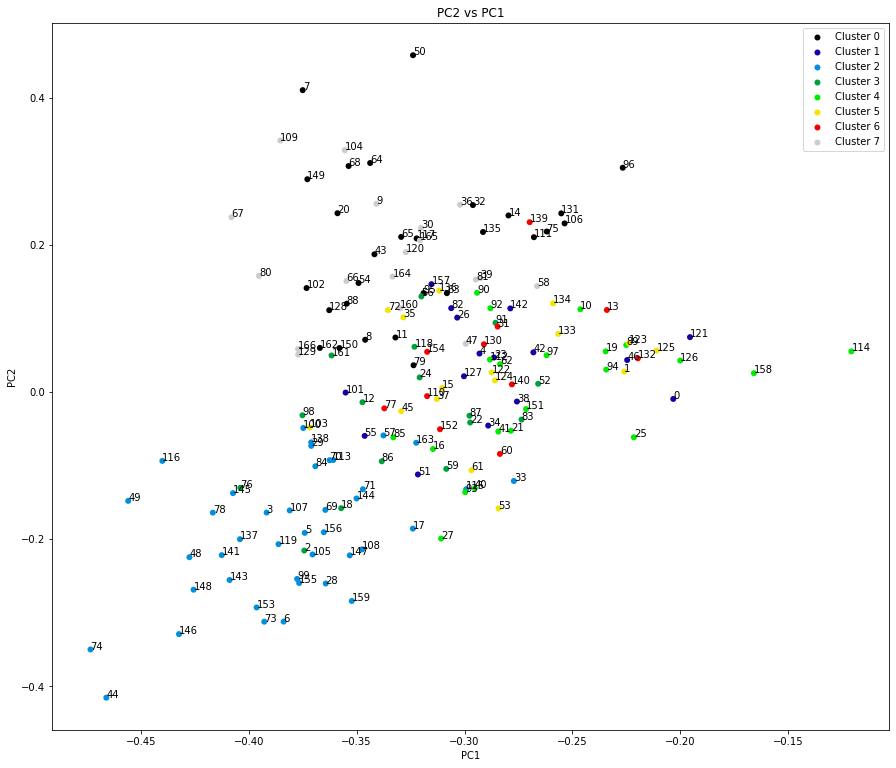

In [64]:
plt.rcParams['figure.figsize'] = [15, 13]

cmap = plt.cm.nipy_spectral
norm = plt.Normalize(pca_df['Cluster'].values.min(), pca_df['Cluster'].values.max())

for i, dff in pca_df.groupby("Cluster"):
    plt.scatter(dff['PCA1'], dff['PCA2'], c=cmap(norm(dff['Cluster'])), 
                edgecolors='none', label="Cluster {:g}".format(i))
    
for i in range(pdata.shape[0]):
    plt.text(pdata[i,0], pdata[i,1], str(i))
    
plt.title('PC2 vs PC1')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.legend()
plt.show()

----

## Spectral Clustering##

In [36]:
li2 = list(range(2,21))
l2 = []
for i in li2:
    mod2 = skc.SpectralClustering(n_clusters = i, random_state = 0)
    lab2 = mod2.fit_predict(samples)
    ss2 = skm.silhouette_score(samples, lab2)
    l2.append(ss2)

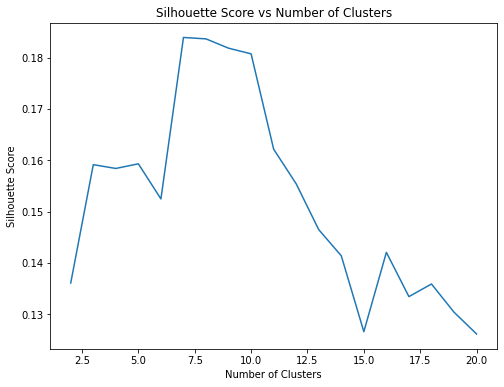

In [37]:
plt.rcParams['figure.figsize'] = [8,6]

plt.plot(li2, l2)
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.show()

In [38]:
mod2 = skc.SpectralClustering(n_clusters = 7, random_state = 0)
lab2 = mod2.fit_predict(samples)

In [39]:
lc2 = pd.DataFrame(labels, columns = ["label"])

In [40]:
lc2['cluster'] = lab2

In [41]:
lc2[lc2['cluster'] == 5]

,label,cluster
2,2. Book page turn.wav,5
12,"12. EGA, LP-4, Dis-Ec-Ch, happy_harmonics.wav",5
18,"18. EGA, LP-3, Dis-Ec, freeing_open.wav",5
22,"22. EGA, LP-3, Ec, dissonant_strange.wav",5
24,"24. EGA, major_staccato.wav",5
52,"52. EGA, Dir, minor_metal.wav",5
56,"56. AG, fragile_dark.wav",5
76,"76. AG, exploratory_coming home.wav",5
83,"83. EGA, LP-3, Dir, minor_wit's end.wav",5
86,"86. AG, Percussion, major.wav",5


In [42]:
pca_df2 = pd.DataFrame(pdata, columns = ['PCA1', 'PCA2'])
pca_df2['Index'] = np.array(range(167))
pca_df2['Cluster'] = lab2

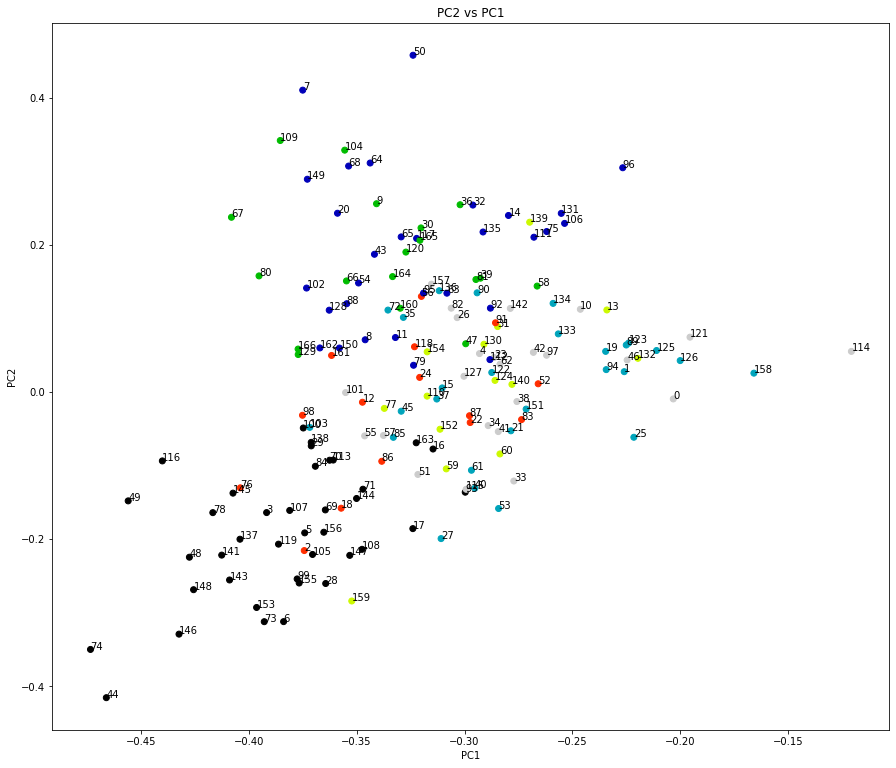

In [43]:
plt.rcParams['figure.figsize'] = [15, 13]

plt.scatter(pca_df2['PCA1'], pca_df2['PCA2'], c = pca_df2['Cluster'], cmap = "nipy_spectral")
plt.title('PC2 vs PC1')
plt.xlabel('PC1')
plt.ylabel('PC2')

for i in range(pdata.shape[0]):
    plt.text(pdata[i,0], pdata[i,1], str(i))

plt.show()

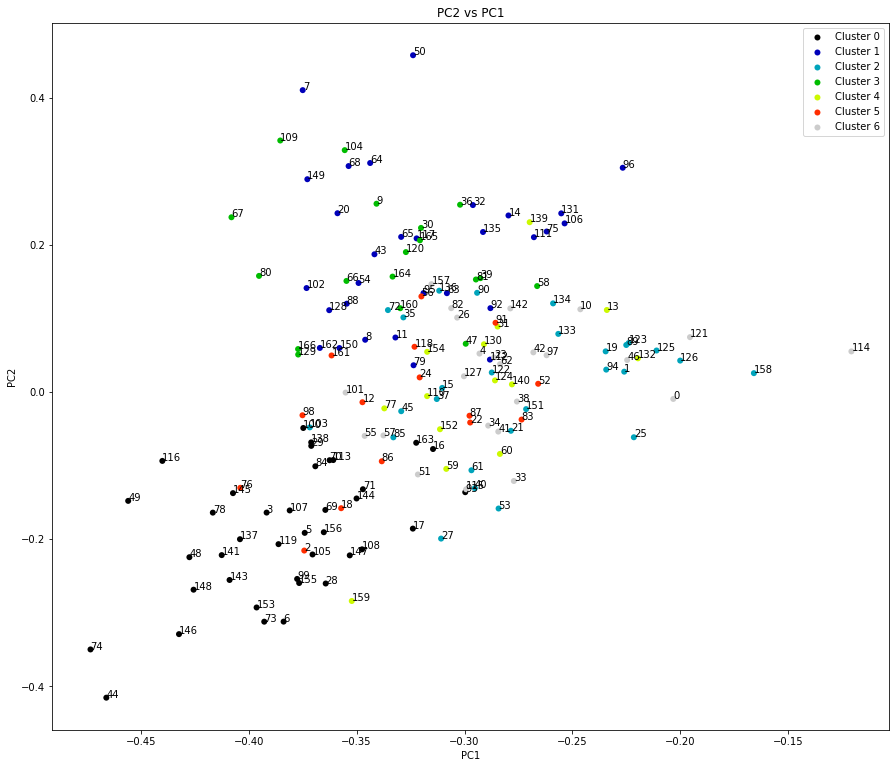

In [63]:
plt.rcParams['figure.figsize'] = [15, 13]

cmap = plt.cm.nipy_spectral
norm = plt.Normalize(pca_df2['Cluster'].values.min(), pca_df2['Cluster'].values.max())

for i, dff in pca_df2.groupby("Cluster"):
    plt.scatter(dff['PCA1'], dff['PCA2'], c=cmap(norm(dff['Cluster'])), 
                edgecolors='none', label="Cluster {:g}".format(i))
    
for i in range(pdata.shape[0]):
    plt.text(pdata[i,0], pdata[i,1], str(i))
    
plt.title('PC2 vs PC1')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.legend()
plt.show()

-----

## Gaussian Mixture##

In [44]:
import sklearn.mixture as skmm

In [45]:
li3 = list(range(2,21))
l3 = []
for i in li3:
    mod3 = skmm.GaussianMixture(n_components = i, random_state = 0)
    lab3 = mod3.fit_predict(samples)
    ss3 = skm.silhouette_score(samples, lab3)
    l3.append(ss3)

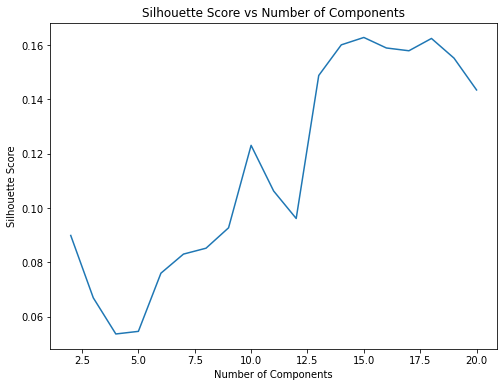

In [46]:
plt.rcParams['figure.figsize'] = [8,6]

plt.plot(li3, l3)
plt.title('Silhouette Score vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')

plt.show()

In [47]:
mod3 = skmm.GaussianMixture(n_components = 15, random_state = 0)
lab3 = mod3.fit_predict(samples)

In [48]:
lc3 = pd.DataFrame(labels, columns = ["label"])

In [49]:
lc3['cluster'] = lab3

In [50]:
lc3[lc3['cluster'] == 1]

,label,cluster
8,"8. AG, thoughtful_nostalgic.wav",1
10,"10. EGA, Dis, minor.wav",1
11,11. Beatbox.wav,1
14,"14. EGA, LP-3, Dis, vulnerable_harmonics.wav",1
15,15. Rain and windshield wipers.wav,1
19,"19. EGA, LP-3, Percussion, happy to urgent.wav",1
21,"21. EGA, Dir-Ec, majestic_finale.wav",1
32,"32. EGA, LP-3-Rev, questioning.wav",1
36,"36. EGA, LP-4, Dis-Wa-Ch-Ec, weird blues.wav",1
43,"43. EGA, LP-2, Dis, jazzy_cool.wav",1


In [51]:
pca_df3 = pd.DataFrame(pdata, columns = ['PCA1', 'PCA2'])
pca_df3['Index'] = np.array(range(167))
pca_df3['Cluster'] = lab3

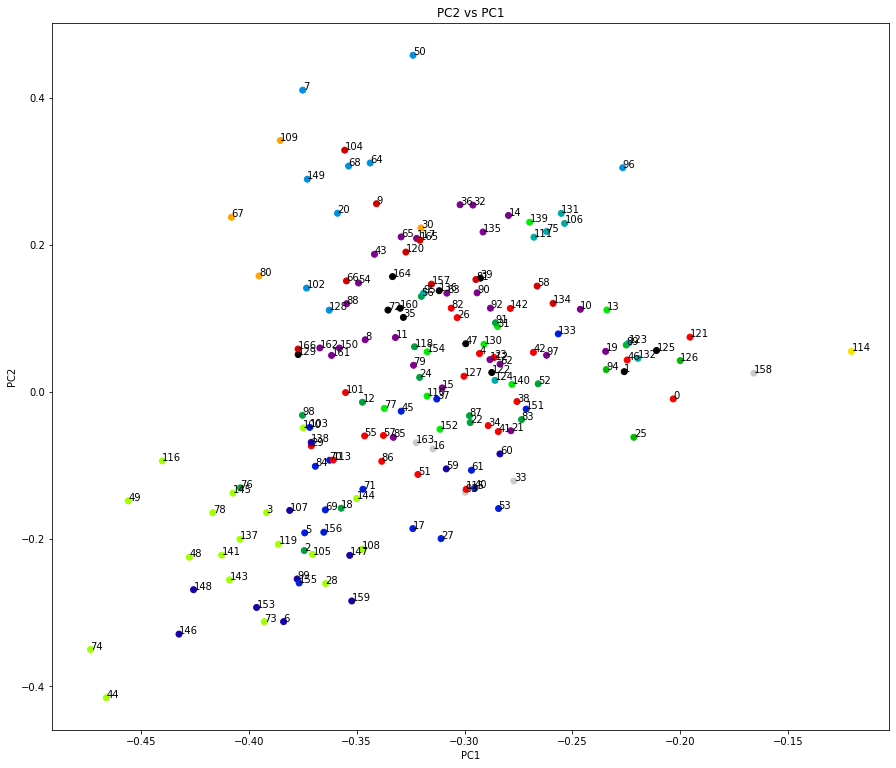

In [52]:
plt.rcParams['figure.figsize'] = [15, 13]

plt.scatter(pca_df3['PCA1'], pca_df3['PCA2'], c = pca_df3['Cluster'], cmap = "nipy_spectral")
plt.title('PC2 vs PC1')
plt.xlabel('PC1')
plt.ylabel('PC2')

for i in range(pdata.shape[0]):
    plt.text(pdata[i,0], pdata[i,1], str(i))

plt.show()

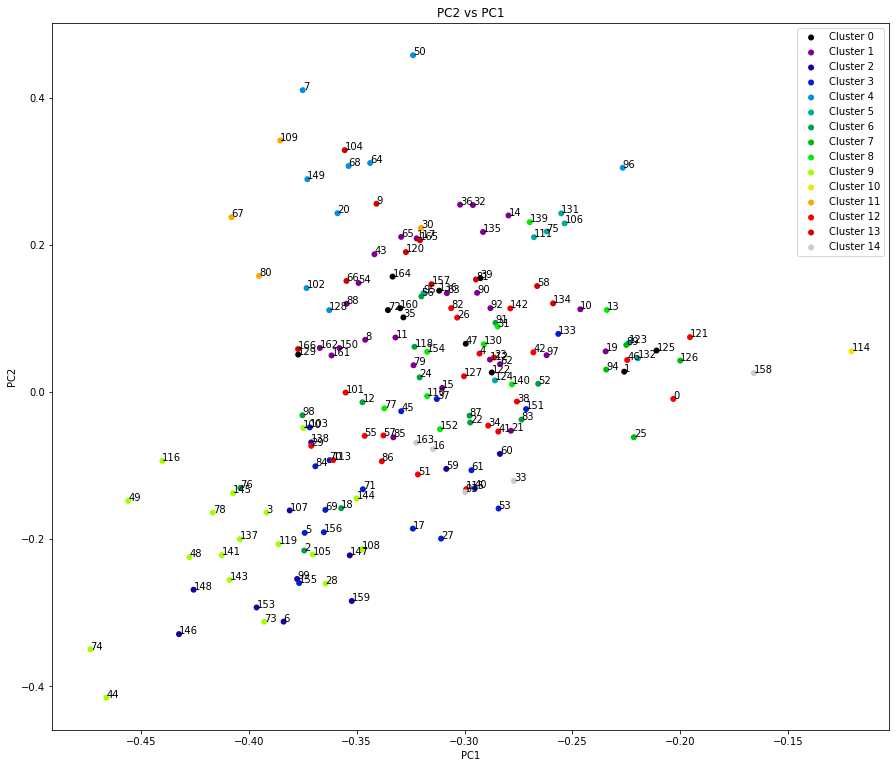

In [62]:
plt.rcParams['figure.figsize'] = [15, 13]

cmap = plt.cm.nipy_spectral
norm = plt.Normalize(pca_df3['Cluster'].values.min(), pca_df3['Cluster'].values.max())

for i, dff in pca_df3.groupby("Cluster"):
    plt.scatter(dff['PCA1'], dff['PCA2'], c=cmap(norm(dff['Cluster'])), 
                edgecolors='none', label="Cluster {:g}".format(i))
    
for i in range(pdata.shape[0]):
    plt.text(pdata[i,0], pdata[i,1], str(i))
    
plt.title('PC2 vs PC1')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.legend()
plt.show()

-----

## Chroma Deviation##

In [53]:
def getChromaDev( audioData ):
    
    ad = audioData[33]
    cd =  np.sum(np.square(ad)) / np.shape(ad)[0]
    
    return cd

In [54]:
def make_df2(filelist):
    for i in filelist:
        pp = preProcess("/Users/samlyon/Desktop/ISYE - 6740/Project/Samples/" + i)
        cd = getChromaDev(pp[1])
        ll.append(cd)
    return ll

In [55]:
ll = []
samples2 = make_df2(labels)

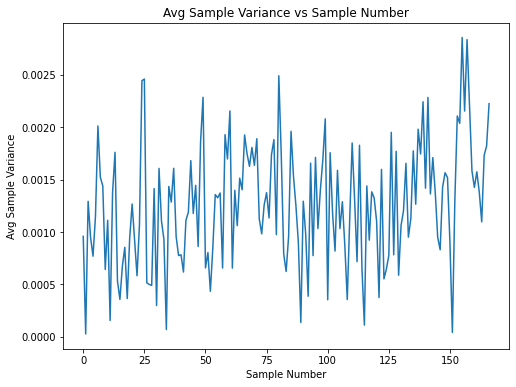

In [65]:
plt.rcParams['figure.figsize'] = [8,6]

plt.plot(list(range(167)), ll)
plt.title('Avg Sample Variance vs Sample Number')
plt.xlabel('Sample Number')
plt.ylabel('Avg Sample Variance')

plt.show()

-------

## Linear Regression##

In [117]:
C0 = np.array([11, 6, 1, 6, 4])
C1 = np.array([3, 3, 0, 8, 2])
C2 = np.array([22, 10, 1, 6, 2])
C3 = np.array([7, 1, 0, 6, 2])
C4 = np.array([4, 4, 0, 10, 3])
C5 = np.array([4, 3, 0, 6, 3])
C6 = np.array([6, 0, 0, 5, 0])
C7 = np.array([10, 3, 0, 4, 1])

CF = np.vstack((C0, C1, C2, C3, C4, C5, C6, C7))

In [96]:
YC_maj = np.array([6, 8, 10, 3, 6, 2, 5, 4])

## Linear Regression##

In [89]:
import sklearn.linear_model as sklm

In [97]:
lin_mod = sklm.LinearRegression()
lin_mod.fit(CF[:6], YC_maj[:6])

LinearRegression()

In [98]:
lin_mod.predict(CF[6:])

array([9.61392405, 4.62025316])

In [99]:
YC_min = np.array([7, 1, 3, 5, 3, 5, 1, 3])

In [100]:
lin_mod2 = sklm.LinearRegression()
lin_mod2.fit(CF[:6], YC_min[:6])
lin_mod2.predict(CF[6:])

array([-0.24050633,  2.46835443])

In [102]:
YC_neither = np.array([16, 7, 28, 8, 12, 9, 5, 11])

In [103]:
lin_mod3 = sklm.LinearRegression()
lin_mod3.fit(CF[:6], YC_neither[:6])
lin_mod3.predict(CF[6:])

array([ 1.56329114, 10.4556962 ])

## Ridge Regression ##

In [173]:
linr_mod = sklm.RidgeCV()
linr_mod.fit(CF[:6, :], YC_maj[:6])
linr_mod.predict(CF[6:])

array([3.37182124, 4.43618325])

In [174]:
linr_mod2 = sklm.RidgeCV()
linr_mod2.fit(CF[:6, :], YC_min[:6])
linr_mod2.predict(CF[6:])

array([0.65177286, 2.60902618])

In [175]:
linr_mod3 = sklm.RidgeCV()
linr_mod3.fit(CF[:6, :], YC_neither[:6])
linr_mod3.predict(CF[6:])

array([ 4.95523499, 10.73094842])

## Lasso ##

In [136]:
C02 = np.array([11, 6, 1, 6, 4, 8, 5])
C12 = np.array([3, 3, 0, 8, 2, 7, 9])
C22 = np.array([22, 10, 1, 6, 2, 12, 8])
C32 = np.array([7, 1, 0, 6, 2, 5, 5])
C42 = np.array([4, 4, 0, 10, 3, 8, 8])
C52 = np.array([4, 3, 0, 6, 3, 8, 4])
C62 = np.array([6, 0, 0, 5, 0, 4, 4])
C72 = np.array([10, 3, 0, 4, 1, 6, 5])

CF2 = np.vstack((C02, C12, C22, C32, C42, C52, C62, C72))

In [137]:
CF2

array([[11,  6,  1,  6,  4,  8,  5],
       [ 3,  3,  0,  8,  2,  7,  9],
       [22, 10,  1,  6,  2, 12,  8],
       [ 7,  1,  0,  6,  2,  5,  5],
       [ 4,  4,  0, 10,  3,  8,  8],
       [ 4,  3,  0,  6,  3,  8,  4],
       [ 6,  0,  0,  5,  0,  4,  4],
       [10,  3,  0,  4,  1,  6,  5]])

In [138]:
linl_mod = sklm.LassoCV()
linl_mod.fit(CF2, YC_maj)

LassoCV()

In [139]:
linl_mod.coef_

array([ 0.18352643,  0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.77624886])

In [140]:
linl_mod2 = sklm.LassoCV()
linl_mod2.fit(CF2, YC_min)

LassoCV()

In [141]:
linl_mod2.coef_

array([ 0.3339434 , -0.49723026, -0.80855962, -0.15326324,  2.23641845,
       -0.12834626, -0.23782095])

In [142]:
linl_mod3 = sklm.LassoCV()
linl_mod3.fit(CF2, YC_neither)

LassoCV()

In [143]:
linl_mod3.coef_

array([ 0.65812887,  0.81383158,  0.        ,  0.32866414,  0.07481893,
        0.42910846, -0.        ])

## Ridge with Lasso variables##

In [144]:
linrr_mod = sklm.RidgeCV()
linrr_mod.fit(CF2[:6, [0,6]], YC_maj[:6])
linrr_mod.predict(CF2[6:, [0, 6]])

array([2.69414833, 4.58505273])

In [145]:
linrr_mod2 = sklm.RidgeCV()
linrr_mod2.fit(CF2[:6, :], YC_min[:6])
linrr_mod2.predict(CF2[6:])

array([4.01700418, 3.93612871])

In [146]:
linrr_mod3 = sklm.RidgeCV()
linrr_mod3.fit(CF2[:6, [0,1,3,4,5]], YC_neither[:6])
linrr_mod3.predict(CF2[6:, [0,1,3,4,5]])

array([4.26789097, 9.91047391])

## Lasso CV Split##

In [176]:
las_mod = sklm.LassoCV()
las_mod.fit(CF2[:6], YC_maj[:6])
las_mod.coef_

array([0.1241938 , 0.21349261, 0.        , 0.        , 0.        ,
       0.        , 0.87528075])

In [177]:
las_mod.predict(CF2[6:])

array([2.37393022, 4.38646401])

In [178]:
las_mod2 = sklm.LassoCV()
las_mod2.fit(CF2[:6], YC_min[:6])
las_mod2.coef_

array([ 0., -0.,  0., -0.,  0., -0., -0.])

In [179]:
las_mod2.predict(CF2[6:])

array([4., 4.])

In [180]:
las_mod3 = sklm.LassoCV()
las_mod3.fit(CF2[:6], YC_neither[:6])
las_mod3.coef_

array([ 0.81201463,  0.6180341 ,  0.        ,  1.08329501,  0.        ,
        0.54115767, -0.51981411])

In [181]:
las_mod3.predict(CF2[6:])

array([ 5.49045793, 10.07182494])